# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# from keras import optimizers
# from keras.models import Sequential
# from keras.layers import TimeDistributed, Flatten
# from keras.layers.core import Dense, Dropout, Activation
# from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
#warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# from keras.models import load_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from tqdm import tqdm

C:\Users\CallO\AppData\Local\Temp\ipykernel_24316\2410309670.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral') # Colour map (there are many others)


# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [202]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [203]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [204]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [205]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [206]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [207]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                 "Section-1",
                 "Section-2",
                 "Section-3",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [208]:
df.head()

,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [209]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
# pt = PowerTransformer()
# df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [210]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500
20627,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197
20628,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991
20629,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466


In [211]:
df=np.nan_to_num(df)

In [212]:
df

array([[0.18373494, 0.40680183, 0.30975692, ..., 0.33333333, 0.71317829,
        0.7246617 ],
       [0.28313253, 0.4530194 , 0.35263336, ..., 0.33333333, 0.66666667,
        0.73101353],
       [0.34337349, 0.36952256, 0.37052667, ..., 0.16666667, 0.62790698,
        0.62137531],
       ...,
       [0.66566265, 0.68497929, 0.77532073, ..., 0.83333333, 0.23255814,
        0.05399061],
       [0.60843373, 0.74602136, 0.74746793, ..., 0.58333333, 0.11627907,
        0.23446562],
       [0.79518072, 0.63963375, 0.84216745, ..., 0.66666667, 0.17829457,
        0.21817178]])

In [213]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [214]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [215]:
X_train = np.array(df)

y_train = np.array(RUL_df()).reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)

(20631, 14) (20631, 1)


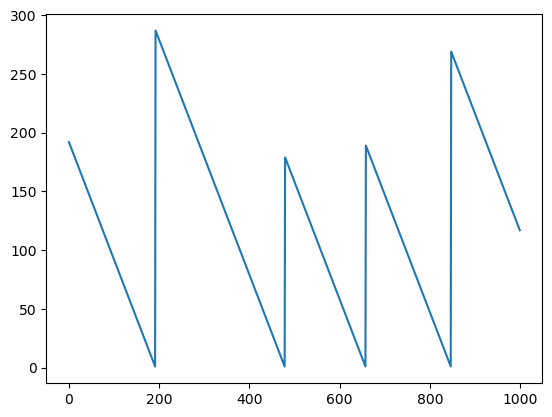

In [216]:
plt.plot(y_train[:1000])

In [217]:
max_cycles

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

In [218]:
max_cycles[5]

188

In [219]:
window_size = 20

X_time = []
y_time = []

for i in range(100):
    i_idx = grp.get_group(i+1).values.reshape(-1)

    for j in range(len(i_idx)-window_size):
        X_time.append(X_train[i_idx[0]+j:i_idx[0]+j+window_size])

    y_time.append(y_train[i_idx[0]+window_size:i_idx[-1]+1])


X_train = np.array(X_time)
y_train = np.concatenate(y_time, axis=0).reshape(-1)

In [220]:
# print(max_cycles)
# print(sum(max_cycles))
# count = 0
# for cycle_len in max_cycles:
#     for i in range(21):
#         y_train[count+i] = 0
#     count = count + cycle_len
# print(count)

In [221]:
# def create_dataset(X, look_back=20):
#     data = []
#     for i in range(len(X)-look_back-1):
#         data.append(X[i:(i+look_back)])
#     return np.array(data)


# X_train = create_dataset(X_train)
# y_train = y_train[21:]

In [222]:
print(X_train.shape,y_train.shape)

(18631, 20, 14) (18631,)


In [223]:
print(y_train)

[171 170 169 ... 281 280 279]


In [224]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [225]:
class LSTMModel(nn.Module):
    def __init__(self, feature_size):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=feature_size, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        
        # Dense layers
        out = self.relu(self.fc1(out[:, -1, :]))  # Take the output of the last time step
        out = self.fc2(out)
        
        return out

# Model instantiation
def build_model(layers):
    model = LSTMModel(layers)
    return model

# Loss and optimizer
model = build_model(X_train.shape[-1]).to(device)  # Example input size (replace with actual layer sizes)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [226]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [227]:
epochs = 75
for epoch in tqdm(range(epochs)):
    model.train()  
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)

        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

  0%|          | 0/75 [00:00<?, ?it/s]d:\Languages\Python\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Languages\Python\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([199])) that is different to the input size (torch.Size([199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|▏         | 1/75 [00:02<02:49,  2.29s/it]

Epoch [1/75], Loss: 17326.0936


  3%|▎         | 2/75 [00:04<02:43,  2.24s/it]

Epoch [2/75], Loss: 17088.1007


  4%|▍         | 3/75 [00:06<02:39,  2.21s/it]

Epoch [3/75], Loss: 16689.3979


  5%|▌         | 4/75 [00:08<02:34,  2.18s/it]

Epoch [4/75], Loss: 16229.3389


  7%|▋         | 5/75 [00:11<02:39,  2.28s/it]

Epoch [5/75], Loss: 15753.9290


  8%|▊         | 6/75 [00:13<02:36,  2.26s/it]

Epoch [6/75], Loss: 15192.7450


  9%|▉         | 7/75 [00:15<02:32,  2.24s/it]

Epoch [7/75], Loss: 14629.5843


 11%|█         | 8/75 [00:17<02:28,  2.22s/it]

Epoch [8/75], Loss: 14019.2896


 12%|█▏        | 9/75 [00:20<02:26,  2.21s/it]

Epoch [9/75], Loss: 13249.8056


 13%|█▎        | 10/75 [00:22<02:22,  2.19s/it]

Epoch [10/75], Loss: 12578.0906


 15%|█▍        | 11/75 [00:24<02:18,  2.17s/it]

Epoch [11/75], Loss: 11888.7502


 16%|█▌        | 12/75 [00:26<02:16,  2.17s/it]

Epoch [12/75], Loss: 10984.9567


 17%|█▋        | 13/75 [00:28<02:13,  2.16s/it]

Epoch [13/75], Loss: 10293.3416


 19%|█▊        | 14/75 [00:30<02:11,  2.15s/it]

Epoch [14/75], Loss: 9544.5329


 20%|██        | 15/75 [00:33<02:12,  2.21s/it]

Epoch [15/75], Loss: 9000.3879


 21%|██▏       | 16/75 [00:35<02:11,  2.22s/it]

Epoch [16/75], Loss: 8271.8689


 23%|██▎       | 17/75 [00:37<02:10,  2.25s/it]

Epoch [17/75], Loss: 7792.8594


 24%|██▍       | 18/75 [00:39<02:09,  2.27s/it]

Epoch [18/75], Loss: 7187.7022


 25%|██▌       | 19/75 [00:42<02:05,  2.24s/it]

Epoch [19/75], Loss: 6762.8922


 27%|██▋       | 20/75 [00:44<02:04,  2.26s/it]

Epoch [20/75], Loss: 6362.2076


 28%|██▊       | 21/75 [00:46<02:05,  2.32s/it]

Epoch [21/75], Loss: 6010.3966


 29%|██▉       | 22/75 [00:49<02:03,  2.33s/it]

Epoch [22/75], Loss: 5767.5001


 31%|███       | 23/75 [00:51<02:03,  2.37s/it]

Epoch [23/75], Loss: 5588.2557


 32%|███▏      | 24/75 [00:54<02:02,  2.40s/it]

Epoch [24/75], Loss: 5415.4251


 33%|███▎      | 25/75 [00:56<01:57,  2.35s/it]

Epoch [25/75], Loss: 5283.1397


 35%|███▍      | 26/75 [00:58<01:57,  2.40s/it]

Epoch [26/75], Loss: 5263.6911


 36%|███▌      | 27/75 [01:01<01:52,  2.35s/it]

Epoch [27/75], Loss: 5157.3228


 37%|███▋      | 28/75 [01:03<01:48,  2.31s/it]

Epoch [28/75], Loss: 5103.1803


 39%|███▊      | 29/75 [01:05<01:44,  2.27s/it]

Epoch [29/75], Loss: 5068.3645


 40%|████      | 30/75 [01:07<01:40,  2.23s/it]

Epoch [30/75], Loss: 5052.6128


 41%|████▏     | 31/75 [01:09<01:36,  2.20s/it]

Epoch [31/75], Loss: 5037.2547


 43%|████▎     | 32/75 [01:11<01:33,  2.18s/it]

Epoch [32/75], Loss: 5019.4395


 44%|████▍     | 33/75 [01:14<01:30,  2.17s/it]

Epoch [33/75], Loss: 5012.9961


 45%|████▌     | 34/75 [01:16<01:28,  2.15s/it]

Epoch [34/75], Loss: 5005.1034


 47%|████▋     | 35/75 [01:18<01:25,  2.15s/it]

Epoch [35/75], Loss: 5044.1413


 48%|████▊     | 36/75 [01:20<01:24,  2.17s/it]

Epoch [36/75], Loss: 5060.6327


 49%|████▉     | 37/75 [01:22<01:24,  2.22s/it]

Epoch [37/75], Loss: 5059.0971


 51%|█████     | 38/75 [01:24<01:20,  2.18s/it]

Epoch [38/75], Loss: 5033.6934


 52%|█████▏    | 39/75 [01:27<01:18,  2.18s/it]

Epoch [39/75], Loss: 5024.2989


 53%|█████▎    | 40/75 [01:29<01:15,  2.16s/it]

Epoch [40/75], Loss: 5015.7247


 55%|█████▍    | 41/75 [01:31<01:13,  2.16s/it]

Epoch [41/75], Loss: 4996.6170


 56%|█████▌    | 42/75 [01:33<01:12,  2.19s/it]

Epoch [42/75], Loss: 5036.2126


 57%|█████▋    | 43/75 [01:35<01:09,  2.18s/it]

Epoch [43/75], Loss: 5013.0117


 59%|█████▊    | 44/75 [01:38<01:07,  2.18s/it]

Epoch [44/75], Loss: 5005.0844


 60%|██████    | 45/75 [01:40<01:05,  2.17s/it]

Epoch [45/75], Loss: 5007.6629


 61%|██████▏   | 46/75 [01:42<01:03,  2.18s/it]

Epoch [46/75], Loss: 5059.0124


 63%|██████▎   | 47/75 [01:44<01:02,  2.23s/it]

Epoch [47/75], Loss: 5018.6337


 64%|██████▍   | 48/75 [01:47<01:01,  2.29s/it]

Epoch [48/75], Loss: 4998.4648


 65%|██████▌   | 49/75 [01:49<00:58,  2.26s/it]

Epoch [49/75], Loss: 5014.3634


 67%|██████▋   | 50/75 [01:51<00:56,  2.25s/it]

Epoch [50/75], Loss: 5024.0897


 68%|██████▊   | 51/75 [01:53<00:53,  2.25s/it]

Epoch [51/75], Loss: 5006.1510


 69%|██████▉   | 52/75 [01:56<00:51,  2.23s/it]

Epoch [52/75], Loss: 5025.4998


 71%|███████   | 53/75 [01:58<00:48,  2.23s/it]

Epoch [53/75], Loss: 5041.1175


 72%|███████▏  | 54/75 [02:00<00:46,  2.23s/it]

Epoch [54/75], Loss: 5027.4496


 73%|███████▎  | 55/75 [02:02<00:44,  2.22s/it]

Epoch [55/75], Loss: 5009.1652


 75%|███████▍  | 56/75 [02:04<00:41,  2.20s/it]

Epoch [56/75], Loss: 5049.9822


 76%|███████▌  | 57/75 [02:06<00:39,  2.18s/it]

Epoch [57/75], Loss: 5017.9693


 77%|███████▋  | 58/75 [02:09<00:38,  2.26s/it]

Epoch [58/75], Loss: 5040.2193


 79%|███████▊  | 59/75 [02:11<00:36,  2.25s/it]

Epoch [59/75], Loss: 5044.4272


 80%|████████  | 60/75 [02:13<00:33,  2.22s/it]

Epoch [60/75], Loss: 5053.2683


 81%|████████▏ | 61/75 [02:16<00:31,  2.22s/it]

Epoch [61/75], Loss: 4991.3107


 83%|████████▎ | 62/75 [02:18<00:28,  2.20s/it]

Epoch [62/75], Loss: 5044.7706


 84%|████████▍ | 63/75 [02:20<00:26,  2.20s/it]

Epoch [63/75], Loss: 5009.5099


 85%|████████▌ | 64/75 [02:22<00:23,  2.18s/it]

Epoch [64/75], Loss: 4999.0761


 87%|████████▋ | 65/75 [02:24<00:21,  2.16s/it]

Epoch [65/75], Loss: 4994.0968


 88%|████████▊ | 66/75 [02:26<00:19,  2.14s/it]

Epoch [66/75], Loss: 5012.0427


 89%|████████▉ | 67/75 [02:28<00:17,  2.14s/it]

Epoch [67/75], Loss: 4993.6769


 91%|█████████ | 68/75 [02:31<00:15,  2.16s/it]

Epoch [68/75], Loss: 5044.2030


 92%|█████████▏| 69/75 [02:33<00:13,  2.23s/it]

Epoch [69/75], Loss: 5030.4865


 93%|█████████▎| 70/75 [02:35<00:11,  2.24s/it]

Epoch [70/75], Loss: 5006.4450


 95%|█████████▍| 71/75 [02:37<00:08,  2.22s/it]

Epoch [71/75], Loss: 4991.1062


 96%|█████████▌| 72/75 [02:40<00:06,  2.22s/it]

Epoch [72/75], Loss: 5020.3555


 97%|█████████▋| 73/75 [02:42<00:04,  2.22s/it]

Epoch [73/75], Loss: 5016.3132


 99%|█████████▊| 74/75 [02:44<00:02,  2.20s/it]

Epoch [74/75], Loss: 5024.4752


100%|██████████| 75/75 [02:46<00:00,  2.22s/it]

Epoch [75/75], Loss: 5029.8888


In [228]:
model(X_train.to(device))

tensor([[111.3910],
        [111.3910],
        [111.3910],
        ...,
        [111.3910],
        [111.3910],
        [111.3910]], grad_fn=<AddmmBackward0>)

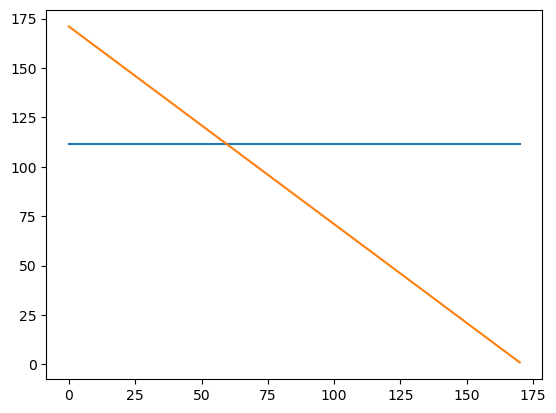

In [229]:
pred = model(X_train[:171].to(device)).detach().cpu().numpy()
plt.plot(pred)
plt.plot(y_train[:171].reshape(-1).numpy())

In [230]:
y_train_pred = model(X_train.to(device)).detach().cpu()
print("mean_squared_error >> ", mean_squared_error(y_train,y_train_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_train,y_train_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_train,y_train_pred))

mean_squared_error >>  5021.7188
root_mean_squared_error >>  70.86408646133809
mean_absolute_error >> 56.11954


# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [5]:
model = load_model('LSTM_with_lookback_20.h5')

In [6]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [7]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [8]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
max_cycles[0] = max_cycles[0] - 21

In [9]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [10]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [11]:
df_test

array([[-1.7938502 ,  1.04936462,  1.00459956, ..., -0.43585161,
        -0.26636316,  0.42059548],
       [-1.75983242, -1.22056415, -1.03515135, ...,  0.37849296,
         0.89958112,  0.64708667],
       [-1.72609272,  0.14086219,  0.34489676, ...,  0.37849296,
         1.36106152,  0.96601877],
       ...,
       [ 1.83603259, -0.26773967, -1.03515135, ...,  1.88097691,
        -1.83688403, -1.50936271],
       [ 1.84590292, -1.71931856,  0.34489676, ...,  1.88097691,
        -1.59013861, -0.80455247],
       [ 1.85572407,  0.59502963,  1.00459956, ...,  2.57907106,
        -1.33736329, -1.7132478 ]])

In [12]:
X_test = np.array(df_test)

y_test = np.array(df_rul)



# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 10  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [13]:
def create_dataset(X, look_back=20):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

In [14]:
X_test = create_dataset(X_test)
#y_test = y_test[6:]

In [15]:
print(X_test.shape,y_test.shape)

(13075, 20, 17) (100, 1)


In [16]:
pred = model.predict(X_test)

In [17]:
pred.shape

(13075, 1)

In [18]:
final_pred = []
count = 0
for i in range(100):
    temp = 0
    j = max_cycles[i] 
    while j>0:
        temp = temp + pred[count]
        j=j-1
        count=count+1
    final_pred.append(int(temp/max_cycles[i]))

In [19]:
print(final_pred)

[116, 154, 84, 81, 97, 102, 118, 87, 100, 117, 29, 106, 115, 28, 150, 154, 49, 50, 120, 60, 89, 112, 153, 71, 86, 108, 115, 79, 138, 84, 40, 56, 80, 80, 45, 38, 95, 51, 84, 53, 83, 76, 81, 122, 82, 55, 26, 105, 99, 89, 99, 123, 89, 115, 146, 23, 76, 80, 120, 96, 61, 113, 77, 73, 64, 54, 87, 88, 95, 92, 63, 78, 112, 88, 94, 92, 66, 105, 99, 82, 39, 46, 94, 90, 89, 102, 129, 66, 95, 83, 38, 29, 63, 73, 91, 80, 55, 76, 134, 109]


In [20]:
final_pred[0]

116

## Using last index as prediction

In [23]:
def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

[108, 117, 20, 43, 48, 55, 102, 43, 105, 89, 26, 91, 104, 13, 191, 207, 25, 12, 152, 0, 53, 153, 100, 10, 123, 55, 48, 79, 57, 61, 0, 29, 61, 0, 0, 0, 14, 19, 114, 0, 26, 0, 34, 134, 36, 15, 44, 59, 0, 67, 57, 17, 14, 140, 173, 0, 65, 30, 66, 82, 5, 38, 41, 6, 82, 0, 87, 0, 91, 46, 38, 31, 113, 98, 60, 0, 23, 107, 57, 40, 0, 0, 80, 40, 123, 49, 81, 33, 47, 11, 0, 0, 13, 26, 78, 74, 57, 24, 117, 10]


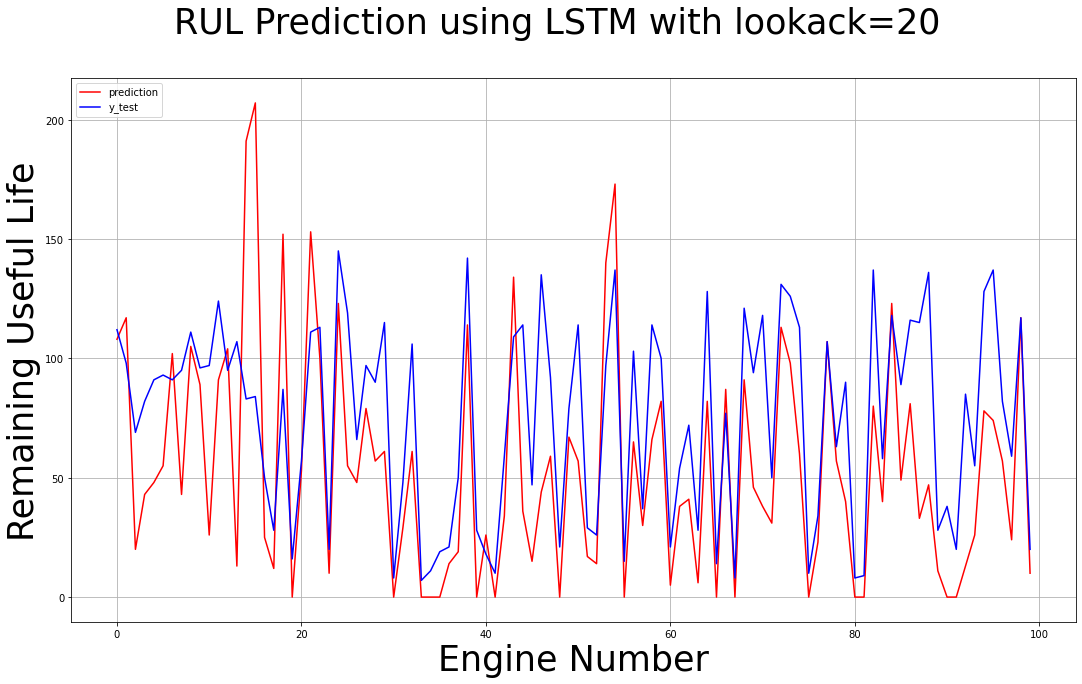

mean_squared_error >>  1629.12
root_mean_squared_error >>  40.362358702137314
mean_absolute_error >> 31.48
scoring function >> 276120.73887349915


In [24]:
final_pred = []
count = 0
for i in range(100):
    j = max_cycles[i] 
    temp = pred[count+j-1]
    count=count+j
    final_pred.append(int(temp))

print(final_pred)


fig = plt.figure(figsize=(18,10))
plt.plot(final_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using LSTM with lookack=20', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

print("mean_squared_error >> ", mean_squared_error(y_test,final_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,final_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,final_pred))
print("scoring function >>",scoring_function(y_test,final_pred))